# Zindi Covid-19 Contest - Data Prep

This notebook shows how the data for the Zindi contest - Predicting the Global Spread of COVID-19 is derived. As this is an evolving situation, the dataset is not fixed at the start of the contest. Instead, you may use all available data at a given time, and are encouraged to keep incorporating new data as it becomes available. Each week, the leaderboard wil reset and a new submission file will be shared covering the most recent test period. The ultimate goal is to make predictions fo the time following the CLOSE of the competition - more info on the competition page.

In this notebook, we download the latest figures from https://github.com/CSSEGISandData/COVID-19, add some additional information, group by Country/Region, re-shape into the format required for submission and show how you can score your model on the latest data without needing to upload submissions to Zindi. 

## Downloading the Data

The data has been curated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE), and is pubically available on their GitHub repository. We clone the repository to get the data.


In [2]:
# Get the latest data
!git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15793 (delta 12), reused 19 (delta 10), pack-reused 15769
Receiving objects: 100% (15793/15793), 61.35 MiB | 8.64 MiB/s, done.
Resolving deltas: 100% (7721/7721), done.


## Loading the Data

In [0]:
import pandas as pd

In [0]:
cases = pd.read_csv('/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411,599
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007,1086
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432,455
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183,1306


In [0]:
deaths = pd.read_csv('/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29,29,29,33,35,40
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,3,4,10


## Adding Population info

This is optional, but this section adds population info.

In [0]:
!pip install countryinfo # Run if needed

     |████████████████████████████████| 204kB 8.5MB/s 
  Created wheel for countryinfo: filename=countryinfo-0.1.0-cp36-none-any.whl size=592040 sha256=fc0f505be99af992b3da1a891cb8d474414dc773cd8d34bba670d119664f2074
  Stored in directory: /root/.cache/pip/wheels/78/59/c4/93bb8e79dcbf95375817c1ecf4c1573bd0c17e9376e2052f95
Successfully built countryinfo


In [0]:
from countryinfo import CountryInfo

pops = {}
fails = []

regions = sorted(deaths['Country/Region'].unique())
for r in regions:
  try:
    country = CountryInfo(r)
    pops[r] = country.info()['population']
  except:
    fails.append(r)
    print('No pop data for', r)

No pop data for Andorra
No pop data for Bahamas, The
No pop data for Cabo Verde
No pop data for Congo (Brazzaville)
No pop data for Congo (Kinshasa)
No pop data for Cote d'Ivoire
No pop data for Cruise Ship
No pop data for Czechia
No pop data for Eswatini
No pop data for Gambia, The
No pop data for Holy See
No pop data for Korea, South
No pop data for Kosovo
No pop data for Montenegro
No pop data for North Macedonia
No pop data for Serbia
No pop data for Taiwan*
No pop data for Timor-Leste
No pop data for US


In [0]:
# Manual fixes
pops['Andorra'] = 76965
pops['Congo (Kinshasa)'] = 81340000
pops["Cote d'Ivoire"] = 24290000
pops['Cruise Ship'] = 2670 # Not included in competition
pops['Czechia'] = 10650000
pops['Holy See'] = 1000 # Also excluded since it's small and unique.
pops['Korea, South'] = 51470000
pops['North Macedonia'] = 2077000
pops['Reunion'] = 859959
pops['Serbia'] = 7022000
pops['Taiwan*'] = 23780000
pops['US'] = 372200000

# More recently added
pops['Congo (Brazzaville)'] = 5261000
pops['Eswatini'] = 1367000
pops['Gambia, The'] = 2101000
pops['Kosovo'] = 1831000
pops['Montenegro'] = 631200

In [0]:
# Adding in population as a column
cols = list(deaths.columns)
deaths['Population'] = deaths['Country/Region'].map(pops)
deaths = deaths[cols[:2]+['Population']+cols[2:]] # Nice ordering
deaths.head()

,Province/State,Country/Region,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,64871000,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,127080000,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29,29
2,NaN,Singapore,5469700,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,27646053,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,30430500,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


## Some Quick Visualizations

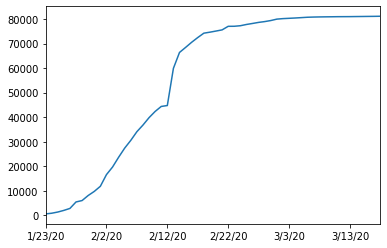

In [0]:
# Cases for mainland China (note - data is cumulative)
cases.groupby('Country/Region').sum().loc['China'][3:].plot()

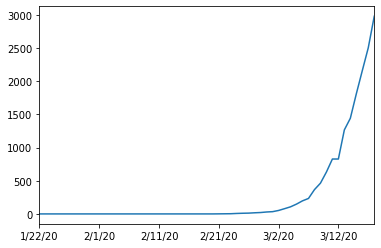

In [0]:
# Deaths in Italy
deaths.groupby('Country/Region').sum().loc['Italy'][3:].plot()

In [0]:
# Looking at raw numbers vs pop adjusted figures
grouped = deaths.groupby('Country/Region').sum()
# grouped['3/12/20'].sort_values(ascending=False).head(20) # Raw numbers
(grouped['3/12/20']*1e7/deaths.groupby('Country/Region').mean()['Population']).sort_values(ascending=False).head(20) # Scaled by population (deaths/10M people)

Country/Region
Cruise Ship     26217.228464
San Marino        916.226369
Italy             136.088896
Iran               55.023703
China              23.202230
Korea, South       12.823004
Guyana             12.740574
Spain              11.825983
Lebanon             7.309942
France              7.264142
Switzerland         4.887705
Albania             3.453102
Netherlands         2.961910
Panama              2.693014
Belgium             2.672494
Iraq                2.221941
Ireland             1.567890
Bulgaria            1.380133
Australia           1.265988
Japan               1.259049
dtype: float64

## Dropping rows to match Zindi

We exclude unusual entries like the cruise ship data, to focus on large regions

In [0]:
deaths = deaths.loc[deaths.Population >10000] # Drops Cruise ship and Holy See
cases = cases.loc[cases['Country/Region'].isin(deaths['Country/Region'].unique())]
deaths.shape, cases.shape

((460, 62), (460, 61))

## Preparing a 'sample submission' file and scoring locally

This will mimic the way submissions to Zindi will work. We'll generate an example submission file along with a reference file (the correct answers, used for scoring). 

Dates for the submission will change as the competition goes on. Here, we'll use the last available week of data for local testing. The next section shows how to create a submission file that can be uploaded to Zindi for scoring.

In [0]:
# Creating the 'reference' file

TEST_PERIOD = 7 # In days

test_dates = deaths.columns[-TEST_PERIOD:] # The last two weeks worth of data
countries = deaths.groupby('Country/Region').sum()[test_dates] # Group by country/region, and select only the columns for the test_period

# Create a new dataframe, with a Region X Date column. 
reference = pd.DataFrame({
    'Region X Date':list(map((lambda x: ' X '.join(x)), list(countries.stack().index.to_flat_index()))), # Check output to see what this is doing
    'target':countries.stack() # The target we'll be predicting: cumulative number of cases for a given region at a given date.
}).reset_index(drop=True) # Don't need the multiIndex created with Stack
reference.to_csv('reference.csv', index=False)
reference.head()

,Region X Date,target
0,Afghanistan X 3/12/20,0
1,Afghanistan X 3/13/20,0
2,Afghanistan X 3/14/20,0
3,Afghanistan X 3/15/20,0
4,Afghanistan X 3/16/20,0


In [0]:
# Sample submission is the same as the reference file, just with target set to 0
print(reference.target.sum())
ss = reference.copy()
ss['target'] = 0
print(ss.target.sum())
ss.to_csv('SampleSub.csv', index=False)

46098
0


In [0]:
# Scoring
from sklearn.metrics import mean_absolute_error

# Create some 'predictions
predictions = ss.copy()
predictions['target'] = 42 # These would be your actual predictions

# Calculate MAE
print('MAE: ', mean_absolute_error(reference['target'], predictions['target']))

MAE:  79.33142857142857


# Matching the Zindi Submission File

The competition requires that you submit a file containing predictions for the whole of the time period between March 6 and June 7. The way it works is that only the relevant week's worth of predictions will be evaluated. Let's create an appropriate file.

In [0]:
dates = pd.date_range(start='2020-03-06', end='2020-06-07', freq='1d')
ids = []
for c in sorted(deaths['Country/Region'].unique()):
  for d in dates:
    ids.append(c + ' X ' + d.strftime('%m/%d/%y'))
ss = pd.DataFrame({
    'Region X Date':ids,
    'target':0
})
ss.to_csv('SampleSubmission.csv', index=False)
ss.head()

,Region X Date,target
0,Afghanistan X 03/06/20,0
1,Afghanistan X 03/07/20,0
2,Afghanistan X 03/08/20,0
3,Afghanistan X 03/09/20,0
4,Afghanistan X 03/10/20,0


In [0]:
ss.tail()

,Region X Date,target
14095,Zambia X 06/03/20,0
14096,Zambia X 06/04/20,0
14097,Zambia X 06/05/20,0
14098,Zambia X 06/06/20,0
14099,Zambia X 06/07/20,0


# Creating 'Train.csv'

You can shape your training data in any way you want, **provided that it does not include data from the test period**. The goal is to predict into the future. While the competition is open, you could simply use all the available data for training and get a near-perfect score. However, this won't represent how well your model will do in the future. The final score will be based on new, unseen data based on events after the competition closes. 

This is how the 'train.csv' file available from Zindi is generated:

In [0]:
train_dates = deaths.columns[5:-TEST_PERIOD]
country_deaths = deaths.groupby('Country/Region').sum()[train_dates] 
country_cases = cases.groupby('Country/Region').sum()[train_dates] 

train = pd.DataFrame({
    'Region X Date':list(map((lambda x: ' X '.join(x)), list(country_deaths.stack().index.to_flat_index()))), 
    'target':country_deaths.stack(),
    'cases':country_cases.stack() # Added as they may be useful
}).reset_index(drop=True)
train.to_csv('train.csv', index=False)
train.head()

,Region X Date,target,cases
0,Afghanistan X 1/22/20,0,0
1,Afghanistan X 1/23/20,0,0
2,Afghanistan X 1/24/20,0,0
3,Afghanistan X 1/25/20,0,0
4,Afghanistan X 1/26/20,0,0


Zindi will update the training data weekly, but you are also encouraged to use the data from JH as shown in this notebook to keep up with the latest information.

# LSTM TS prediction

In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm 
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = (12, 6)
register_matplotlib_converters()

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Data exploration

In [4]:
df = pd.read_csv('/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411,599,599.0
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007,1086,1086.0
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432,455,455.0
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2.0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183,1306,1306.0


In [5]:
df = df.iloc[:, 4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411,599,599.0
1,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007,1086,1086.0
2,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432,455,455.0
3,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2.0
4,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183,1306,1306.0


In [6]:
df.isnull().sum().sum()

192

In [7]:
daily_cases = df.sum(axis=0)
daily_cases.head()

1/22/20     555.0
1/23/20     653.0
1/24/20     941.0
1/25/20    1434.0
1/26/20    2118.0
dtype: float64

In [0]:
daily_cases.index = pd.to_datetime(daily_cases.index)

In [0]:
daily_cases = daily_cases[:41]

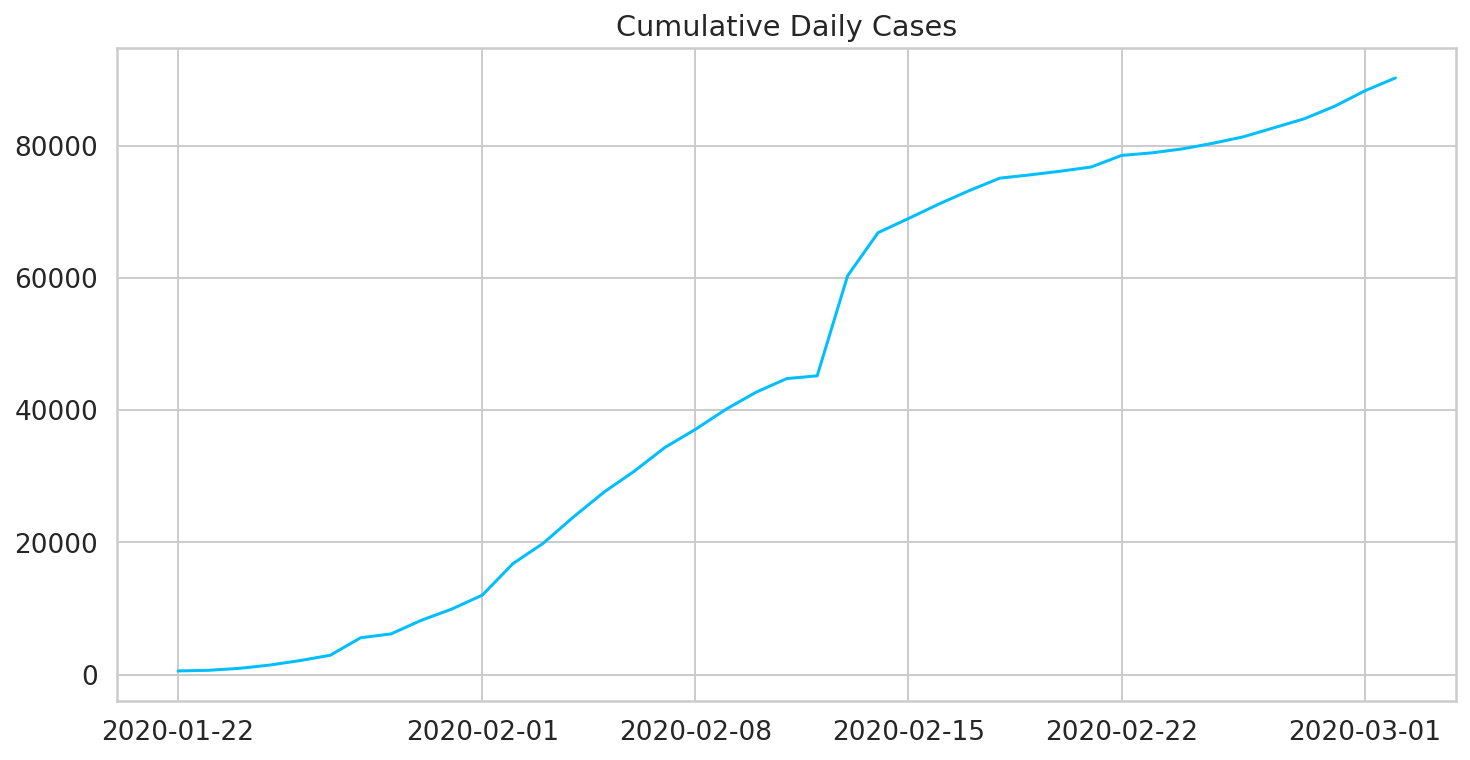

In [10]:
plt.plot(daily_cases)
plt.title('Cumulative Daily Cases');

In [0]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)

In [0]:
# daily_cases = daily_cases.apply(np.log1p)

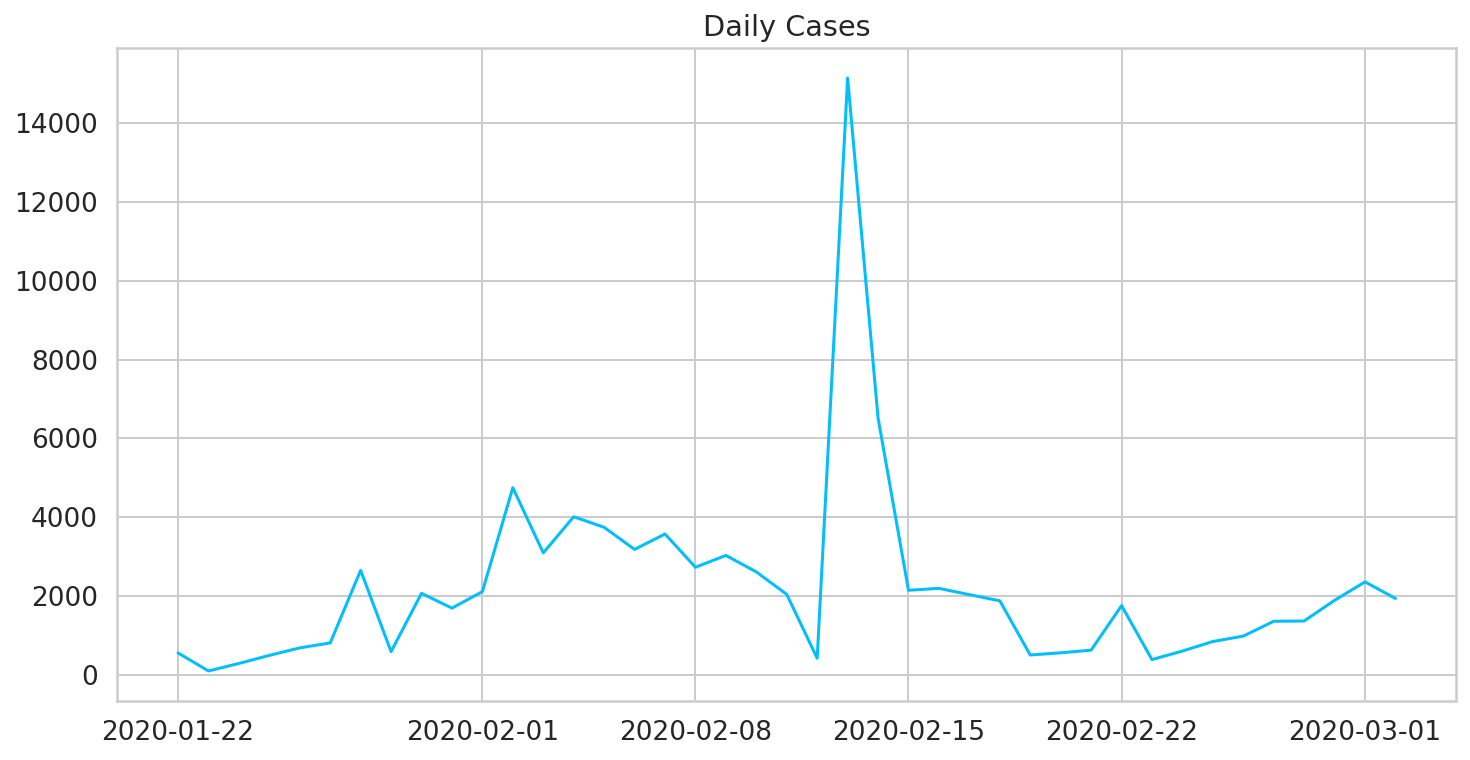

In [0]:
plt.plot(daily_cases)
plt.title('Daily Cases');

## Preprocessing

In [13]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape, test_data.shape

((27,), (14,))

In [0]:
scaler = MinMaxScaler().fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [0]:
def sliding_windows(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length - 1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [16]:
seq_length = 5

X_train, y_train = sliding_windows(train_data, seq_length)
X_test, y_test = sliding_windows(test_data, seq_length)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21, 5, 1), (8, 5, 1), (21, 1), (8, 1))

In [0]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

# Building a model

In [0]:
class CovidPredictor(nn.Module):

    def __init__(self, input_dim, hidden_dim, seq_len, num_layers=2):
      super(CovidPredictor, self).__init__()

      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.seq_len = seq_len
      self.num_layers = num_layers

      self.lstm = nn.LSTM(
          input_size=input_dim, 
          hidden_size=hidden_dim,
          num_layers=num_layers, 
          dropout=0.5
      )

      self.linear = nn.Linear(in_features=hidden_dim, out_features=1)

    def reset_hidden_state(self):
      self.hidden = (
          torch.zeros(self.num_layers, self.seq_len, self.hidden_dim),
          torch.zeros(self.num_layers, self.seq_len, self.hidden_dim)
      )

    def forward(self, input):
      lstm_out, self.hidden = self.lstm(
          input.view(len(input), self.seq_len, -1),
          self.hidden
      )
      y_pred = self.linear(
          lstm_out.view(self.seq_len, len(input), self.hidden_dim)[-1]
      )

      return y_pred

In [0]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):

    loss_fn = nn.MSELoss(reduction='sum')

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 60

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)

        if test_data is not None:
            with torch.no_grad():
              y_test_pred = model(X_test)
              test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()

            if t % 10 == 0:
              print(f'Epoch {t} train loss: {loss.item()}, test_loss: {test_loss.item()}')
        elif t % 10 == 0:
          print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()
        optimizer.zero_grad()
        optimizer.step()

    return model.eval(), train_hist, test_hist

In [20]:
model = CovidPredictor(1, 512, seq_len=seq_length, num_layers=2)

model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 3.955915927886963, test_loss: 1.2958604097366333
Epoch 10 train loss: 3.980360746383667, test_loss: 1.2820020914077759
Epoch 20 train loss: 3.963350534439087, test_loss: 1.2861251831054688
Epoch 30 train loss: 3.9841036796569824, test_loss: 1.2896144390106201
Epoch 40 train loss: 3.970883846282959, test_loss: 1.287078619003296
Epoch 50 train loss: 3.983020305633545, test_loss: 1.281020164489746


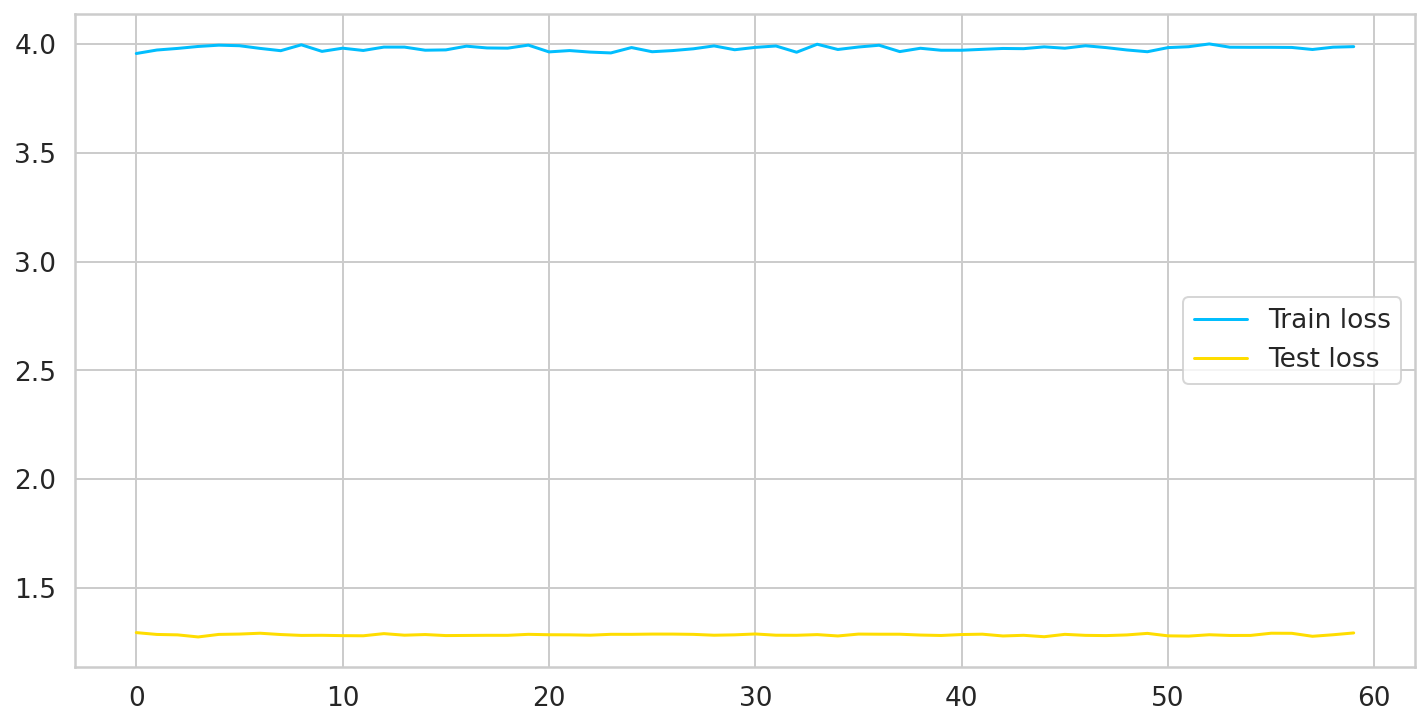

In [21]:
plt.plot(train_hist, label='Train loss')
plt.plot(test_hist, label='Test loss')
plt.legend();

## Predicting daily cases

In [0]:
with torch.no_grad():
   test_seq = X_test[:1]
   preds = []
   for _ in range(len(X_test)):
      y_test_pred = model(test_seq)
      pred = torch.flatten(y_test_pred).item()
      preds.append(pred)

      new_seq = test_seq.numpy().flatten()
      new_seq = np.append(new_seq, [pred])
      new_seq = new_seq[1:]
      test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

In [0]:
predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
).flatten()

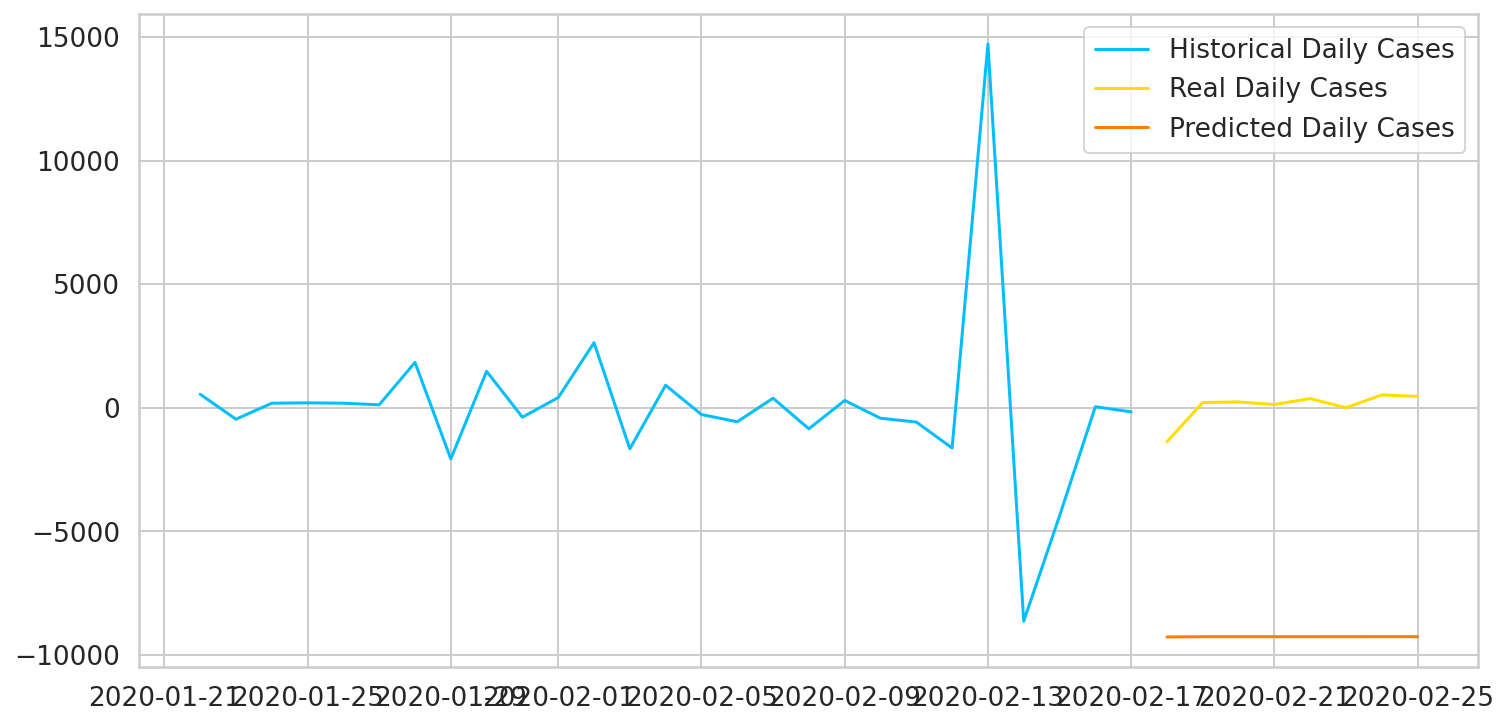

In [25]:
plt.plot(daily_cases.index[:len(train_data)],
         scaler.inverse_transform(train_data).flatten(),
         label='Historical Daily Cases'
)
plt.plot(daily_cases.index[len(train_data):len(train_data)+len(true_cases)],
         true_cases,
         label='Real Daily Cases'
)
plt.plot(daily_cases.index[len(train_data):len(train_data)+len(true_cases)],
         predicted_cases,
         label='Predicted Daily Cases'
)
plt.legend();

## Use all data for training

In [28]:
scaler = MinMaxScaler().fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(41, 1)

In [0]:
X_all, y_all = sliding_windows(all_data, seq_length)

In [0]:
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

In [31]:
model = CovidPredictor(1, 512, seq_len=seq_length, num_layers=2)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 3.8780102729797363
Epoch 10 train loss: 3.862544536590576
Epoch 20 train loss: 3.863994598388672
Epoch 30 train loss: 3.8796589374542236
Epoch 40 train loss: 3.8467702865600586
Epoch 50 train loss: 3.8733670711517334


In [0]:
DAYS_TO_PREDICT = 7
with torch.no_grad():
   test_seq = X_test[:1]
   preds = []
   for _ in range(DAYS_TO_PREDICT):
      y_test_pred = model(test_seq)
      pred = torch.flatten(y_test_pred).item()
      preds.append(pred)

      new_seq = test_seq.numpy().flatten()
      new_seq = np.append(new_seq, [pred])
      new_seq = new_seq[1:]
      test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
).flatten()

In [34]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

In [0]:
predicted_index = pd.date_range(
    start=daily_cases.index[-1],
    periods=DAYS_TO_PREDICT + 1,
    closed = 'right'
    )

In [0]:
predicted_cases = pd.Series(
    data=predicted_cases,
    index=predicted_index
)

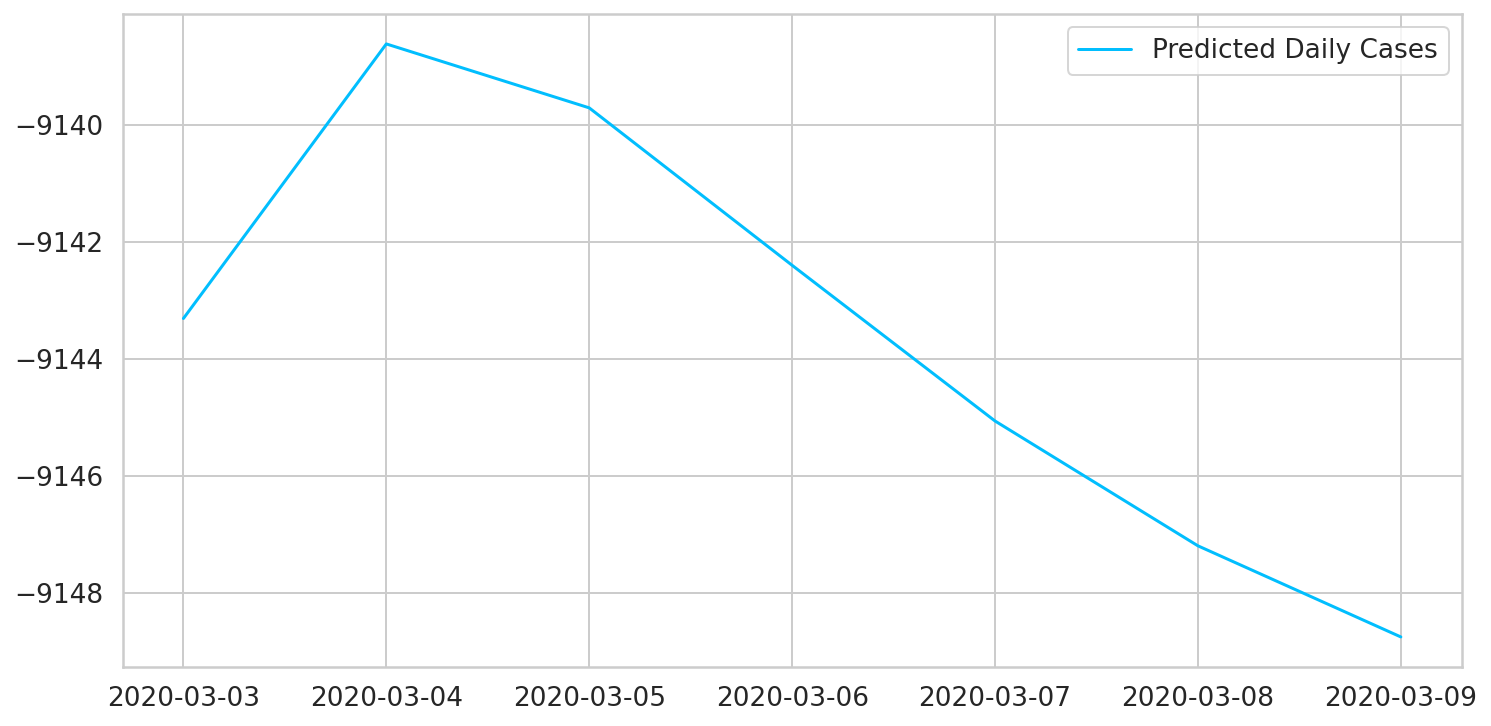

In [39]:
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

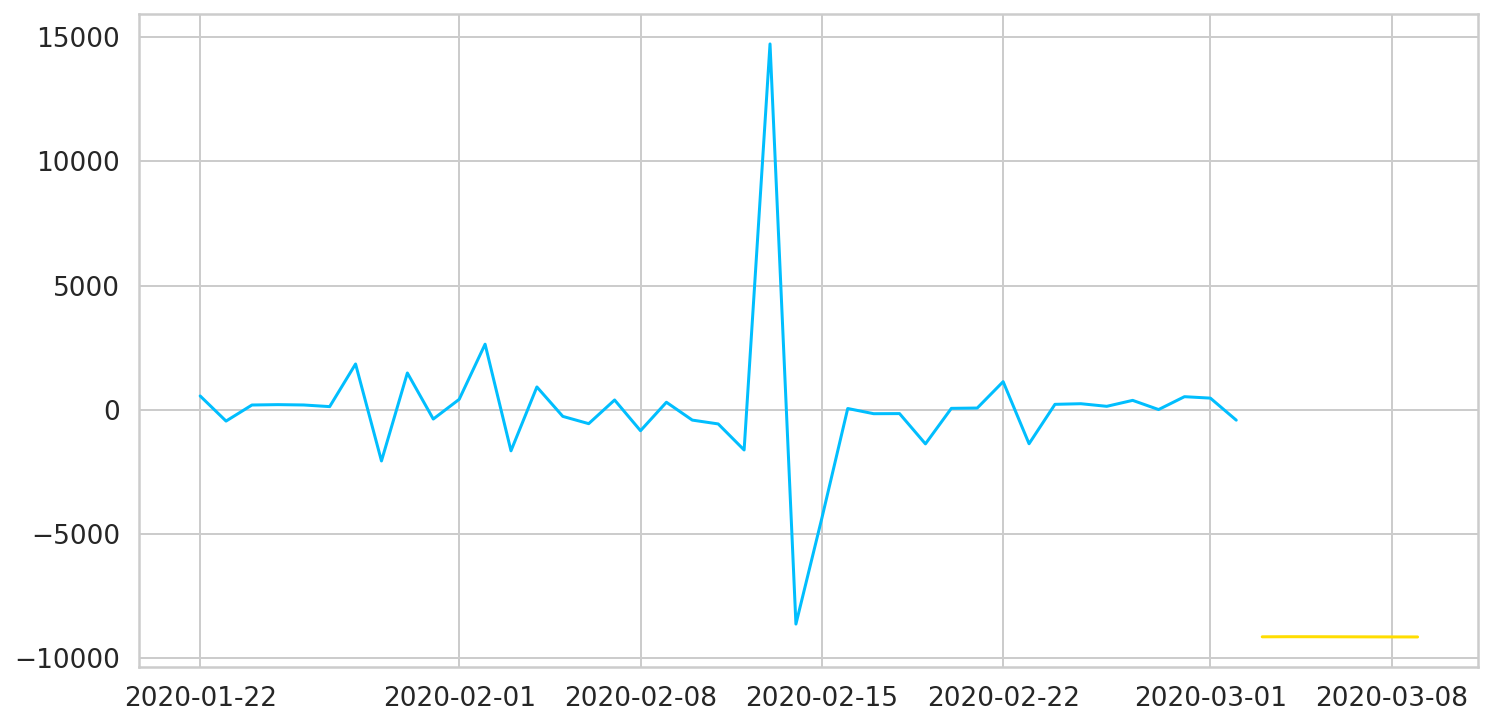

In [40]:
plt.plot(daily_cases, label='History Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')